In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Statevector

sim = QasmSimulator() # making new simulator object

# Loading the IBM Quantum account(s)

provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from qiskit import QuantumCircuit

In [3]:
# a similar code snippet as below can be used to run a ciruit on a real QC

# from qiskit.providers.ibmq import least_busy
# provider = IBMQ.load_account()

# backend = least_busy(provider.backends(filters = lambda x: x.configuration().n_qubits >= (n+1) and not x.configuration().simulator and x.status().operational == 1))

# print("least busy backend:", backend)

# job = execute(shor_program(n, m, a), backend = backend, shots = 1000, optimization_level = 3)

In [4]:
from math import gcd
from fractions import Fraction

In [40]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [45]:
c_amod15(7, 3)


Instruction(name='c7^3 mod 15', num_qubits=5, num_clbits=0, params=[])

In [ ]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    
    qc.name = "QFT†"
    
    return qc

qft_dagger(4).draw()

#alternatively call QFT inverse using a code like this: given_circuit.append(QFT(len(measurement_qubits), do_swaps = True, inverse = True), measurement_qubits)

In [36]:
def qpe_amod15(a):
    n_count = 1
    qc = QuantumCircuit(4+n_count, n_count)
    
    for q in range(n_count):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(3+n_count) # And auxiliary register in state |1>
    
    for q in range(n_count): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q), 
                 [q] + [i+n_count for i in range(4)])
    
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
    qc.measure(range(n_count), range(n_count))
    
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    
    # Setting memory=True below allows us to see a list of each sequential reading
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc, shots=1)
    
    result = aer_sim.run(qobj, memory=True).result()
    
    readings = result.get_memory()
    print("Register Reading: " + readings[0])
    
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    
    return phase

In [37]:
N = 15
a = 2

factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: r = %i" % r)
    
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
    
    for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True


Attempt 1:
Register Reading: 0
Corresponding Phase: 0.000000
Result: r = 1
*** Non-trivial factor found: 3 ***


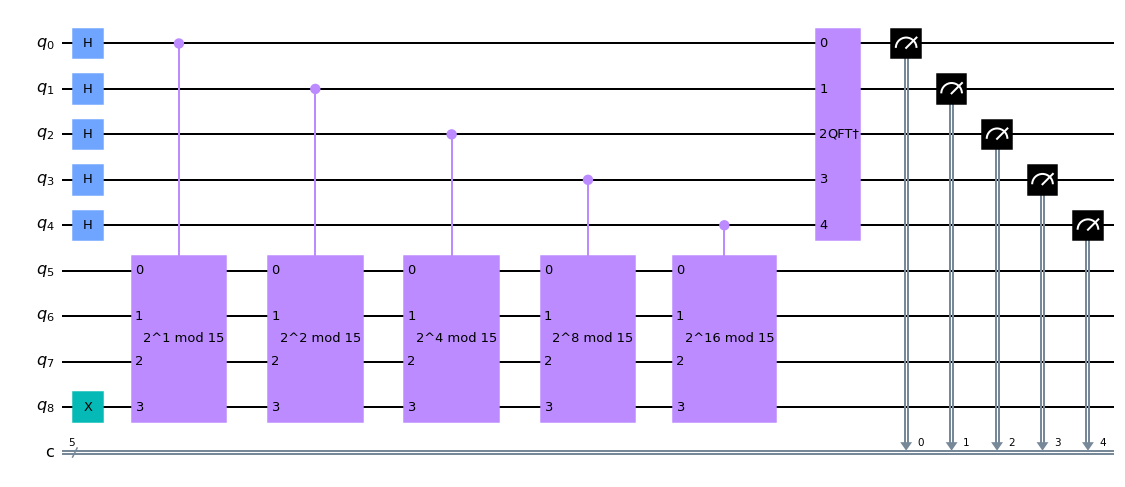

In [39]:
n_count = 5
qc = QuantumCircuit(4+n_count, n_count)

for q in range(n_count):
    qc.h(q)     # Initialize counting qubits in state |+>
    
qc.x(3+n_count) # And auxiliary register in state |1>

for q in range(n_count): # Do controlled-U operations
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])
    
qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
qc.measure(range(n_count), range(n_count))

qc.draw()